In [1]:
import pandas as pd
import sys
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import statsmodels.api as sm

print("Packages Imported")

Packages Imported


In [2]:
# settings
PROJECT_PATH = 'G:/Shared drives/visual_encoding'
SPIKES_IN = 'data/spike_data/synchrony_data'
LFP_IN = 'data/lfp_data/lfp_params'
REPO_PATH = 'C:/Users/User/visual_encoding'

In [3]:
# define utility functions

# take the median over all channels for each epoch
def channel_medians(lfp_df, col_names):
    #imports
    import numpy as np
    
    medians = [0]*len(col_names)
    for epoch in lfp_df.get("epoch_idx").unique():
        epoch_df = lfp_df[lfp_df.get("epoch_idx")==epoch]
        medians = np.vstack((medians, epoch_df.median()))

    medians = np.delete(medians, (0), axis=0)
    return pd.DataFrame(data = medians, columns = col_names)#.drop(columns = 'chan_idx')

# compare linear regression plots between movie and shuffled conditions for two variables
def linregress_movie_v_shuffled_plot(x1, y1, x2=None, y2=None, title=None, xlabel=None, ylabel=None):
    import scipy.stats as sts
    
    #natural_movie
    m1 = sts.linregress(x1, y1)
    l1 = np.linspace(min(x1), max(x1), 1000)
    t1 = m1.slope * l1 + m1.intercept
    
    #shuffled
    m2 = sts.linregress(x2, y2)
    l2 = np.linspace(min(x2), max(x2), 1000)
    t2 = m2.slope * l2 + m2.intercept
    
    plt.style.use('bmh')
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot()
    
    plt.scatter(x1, y1)
    plt.plot(l1, t1, label='natural_movie (1)')
    plt.scatter(x2, y2)
    plt.plot(l2, t2, label='shuffled (2)')
    plt.legend()
    
    # add labels
    plt.text(1.05, 0.95, f"Slope1: {round(m1.slope, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.9, f"R1: {round(m1.rvalue, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.85, f"Intercept1: {round(m1.intercept, 5)}", transform = ax.transAxes)
    
    plt.text(1.05, 0.75, f"Slope2: {round(m2.slope, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.7, f"R2: {round(m2.rvalue, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.65, f"Intercept2: {round(m2.intercept, 5)}", transform = ax.transAxes)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

In [4]:
# load spike metric data
movie_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie.csv')
# load lfp psd data
movie_lfp_df = pd.read_csv(f'{PROJECT_PATH}/{LFP_IN}/natural_movie/all_params.csv').drop(columns="Unnamed: 0").drop(columns="Unnamed: 0.1")

In [5]:
shuffled_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie_shuffled.csv')
shuffled_lfp_df = pd.read_csv(f'{PROJECT_PATH}/{LFP_IN}/natural_movie_shuffled/lfp_params.csv')

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


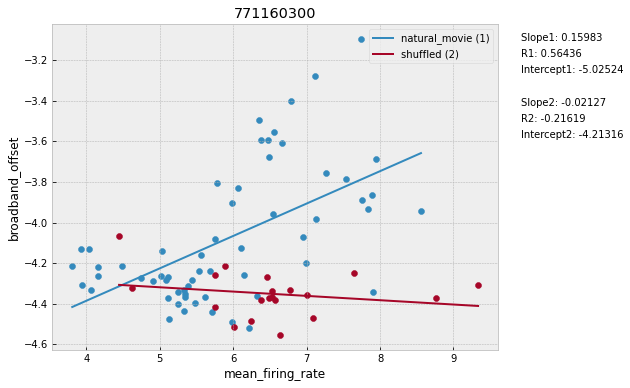

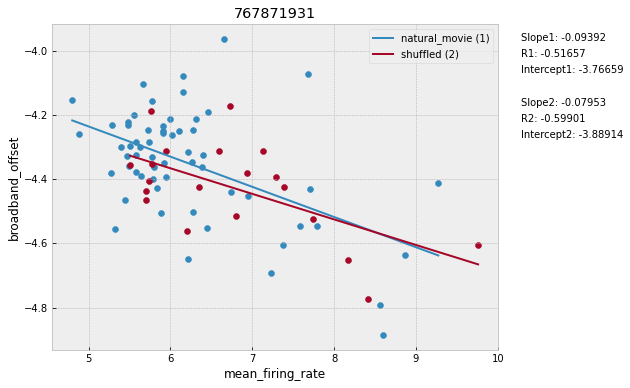

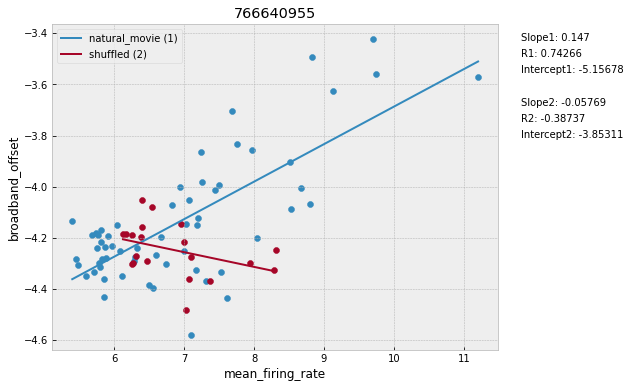

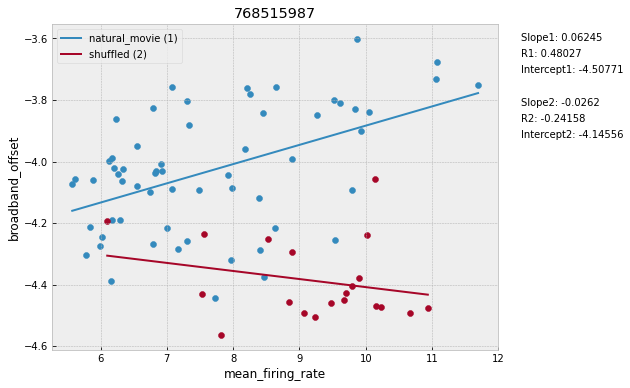

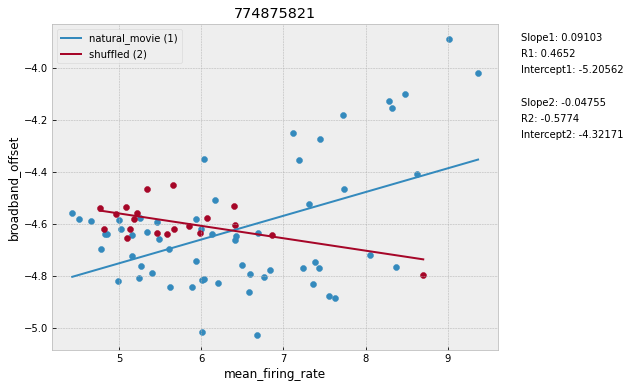

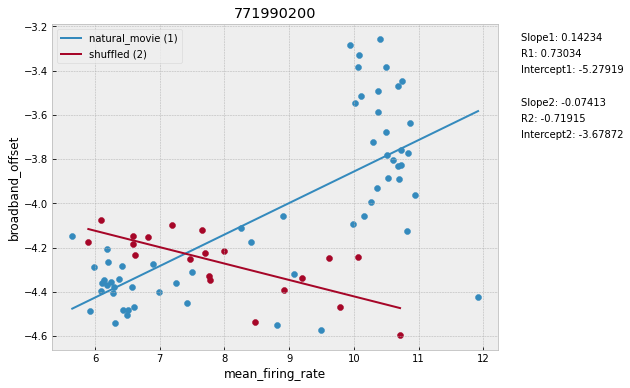

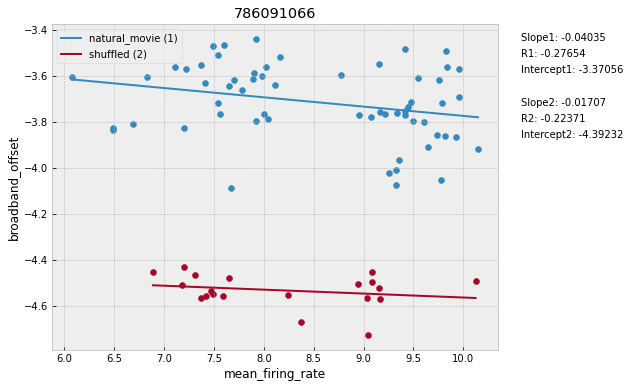

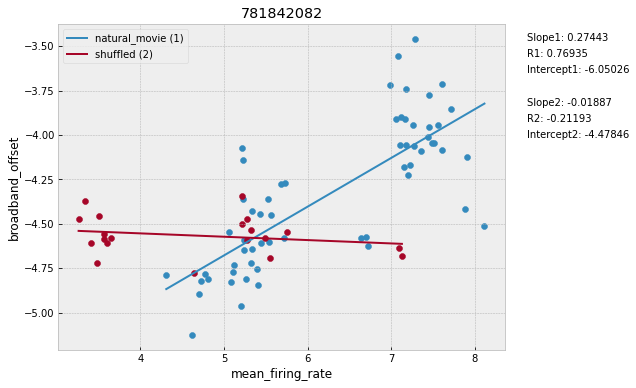

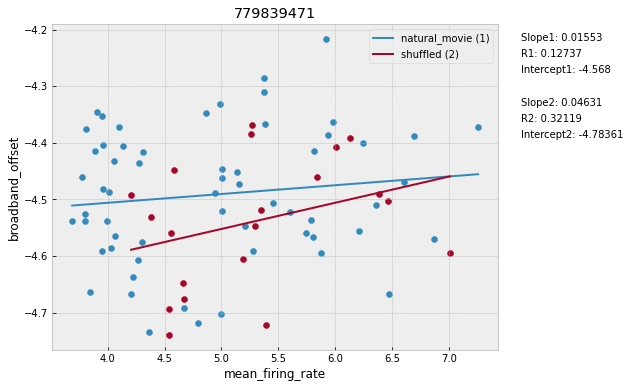

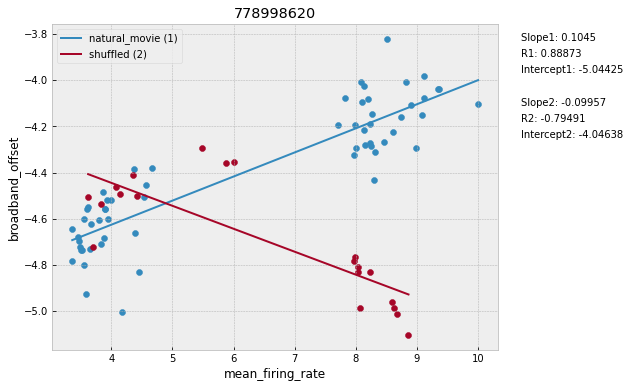

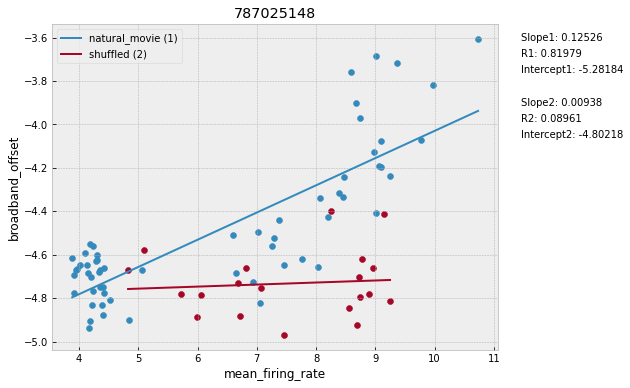

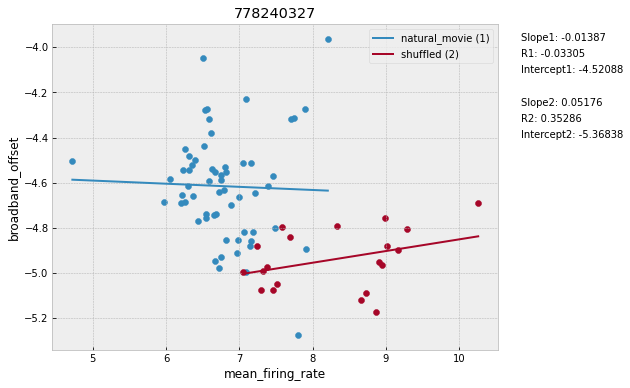

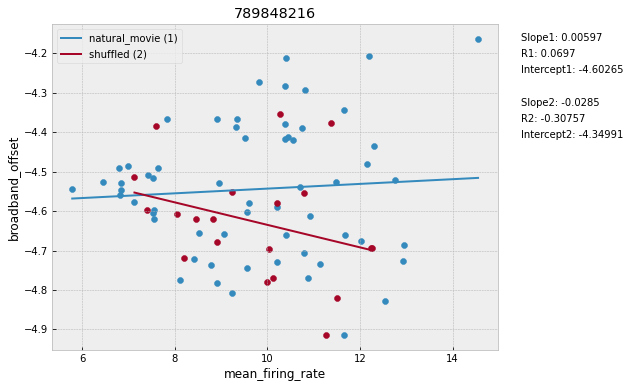

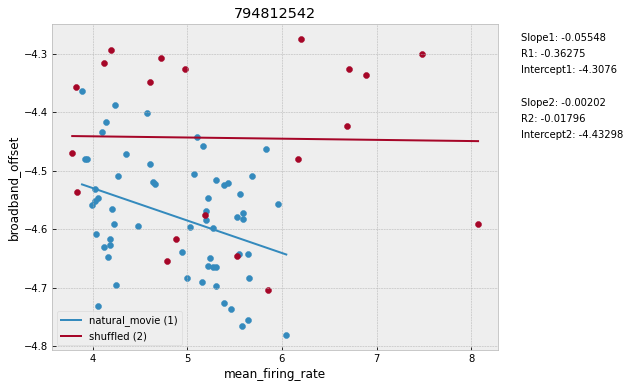

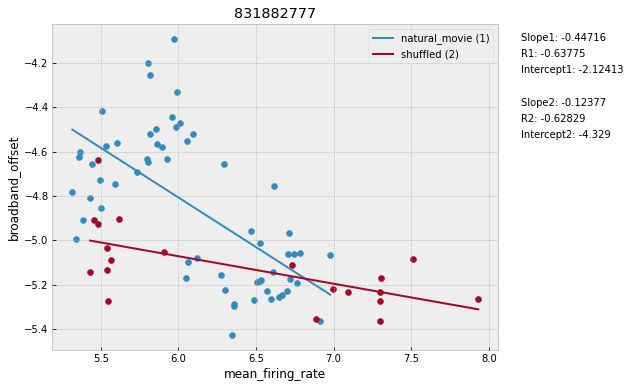

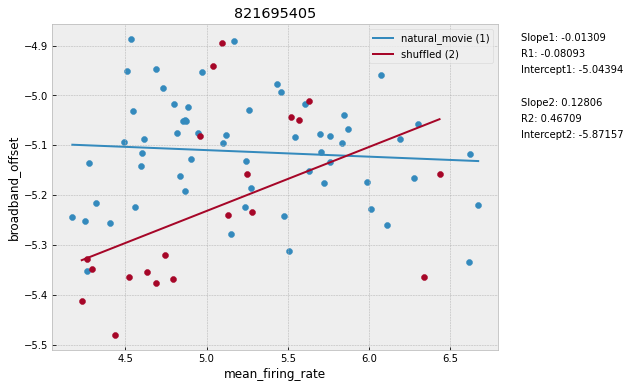

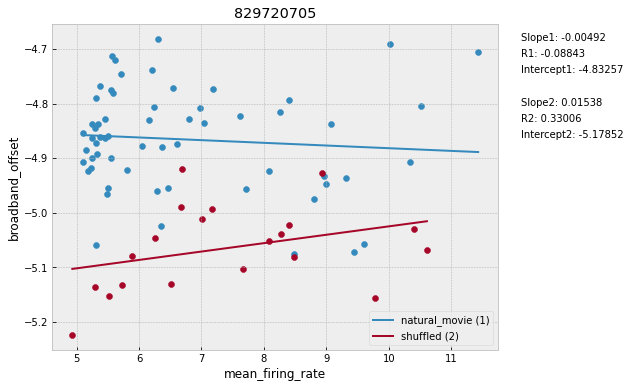

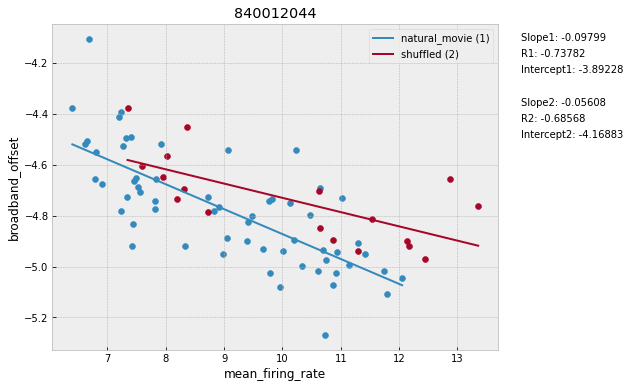

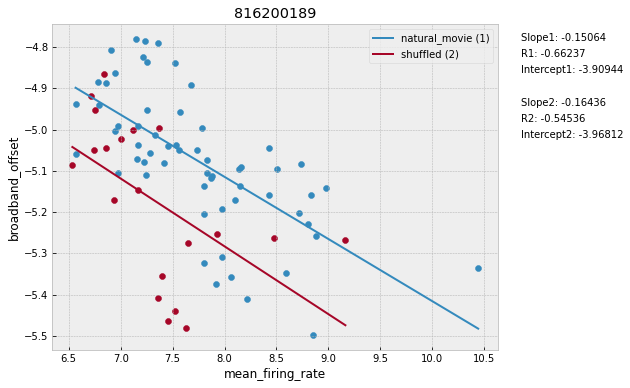

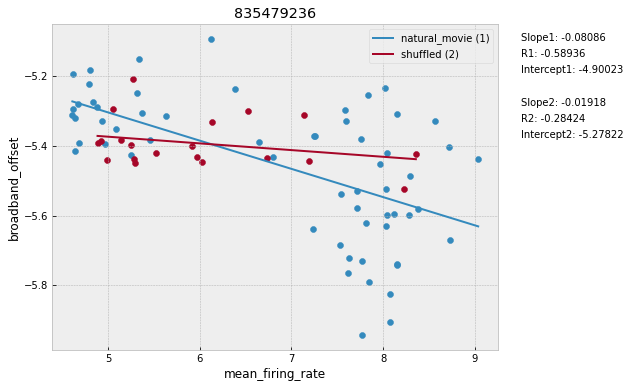

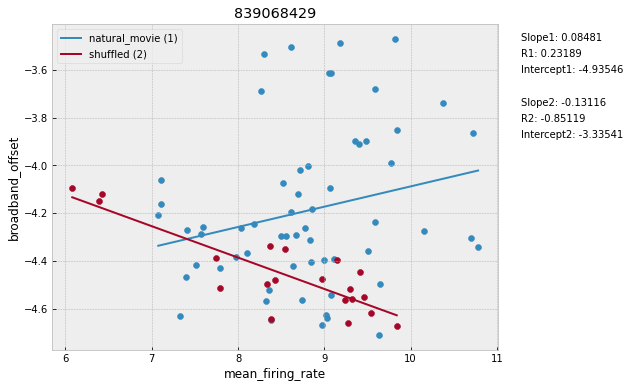

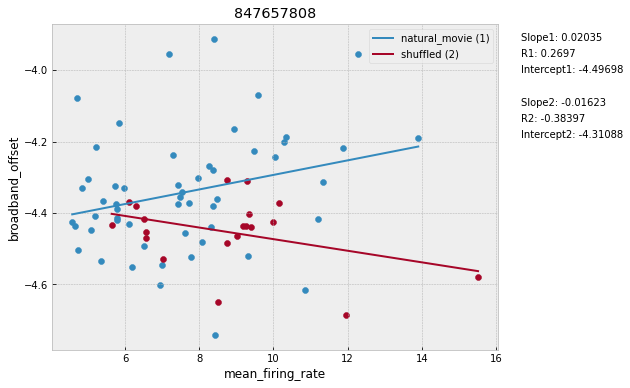

In [44]:
# iterate over each session and join dataframes
for ses_id in movie_synchrony_df.get('session_id').unique():
    # filter by region
    vis_movie_synchrony_df = movie_synchrony_df[movie_synchrony_df.get('brain_structure')=='VISp']
    
    # filter by session
    ses_df = vis_movie_synchrony_df[vis_movie_synchrony_df.get('session_id')==ses_id]
    vis_movie_ses_df = ses_df.assign(epoch_idx = ses_df.get('state').apply(lambda x: float(x.split("_")[-1])))
    ses_df = movie_lfp_df[movie_lfp_df.get('session')==ses_id]
    
    # find median of lfp metrics across channels
    movie_lfp_ses_df = channel_medians(ses_df, ses_df.columns).drop(columns="chan_idx")
    
    # join dataframes
    movie_lfp_sync = movie_lfp_ses_df.merge(vis_movie_ses_df)
    
    # create plots
    x_movie = movie_lfp_sync.get('mean_firing_rate')
    y_movie = movie_lfp_sync.get('offset')
    
    # repeat for shuffled data
    vis_shuffled_synchrony_df = shuffled_synchrony_df[shuffled_synchrony_df.get('brain_structure')=='VISp']
    
    ses_df = vis_shuffled_synchrony_df[vis_shuffled_synchrony_df.get('session_id')==ses_id]
    vis_shuffled_ses_df = ses_df.assign(epoch_idx = ses_df.get('state').apply(lambda x: float(x.split("_")[-1])))
    ses_df = shuffled_lfp_df[shuffled_lfp_df.get('session')==ses_id]

    shuffled_lfp_ses_df = channel_medians(ses_df, ses_df.columns).drop(columns="chan_idx")
    
    shuffled_lfp_sync = shuffled_lfp_ses_df.merge(vis_shuffled_ses_df)
    
    x_shuffled = shuffled_lfp_sync.get('mean_firing_rate')
    y_shuffled = shuffled_lfp_sync.get('offset')
    linregress_movie_v_shuffled_plot(x_movie, y_movie, x_shuffled, y_shuffled, ses_id, "mean_firing_rate", "broadband_offset");

### Merge unit and lfp results

In [45]:
# Merge unit and lfp dataframes (after necessary modifications)

# modify df_lfp - average over channels for each epoch within each session
df_lfp = movie_lfp_df.groupby(['session', 'epoch_idx']).mean().reset_index()

# modify df_unit - drop non-VISp rows
df_units = movie_synchrony_df.copy()
df_units = df_units[df_units.get("brain_structure")=="VISp"]    

# modify df_unit - match column names to df_lfp for merging
# NOTE - spike_pipeline/3_compute_spike_stats.py has been updated to do this
df_units['session'] = df_units['session_id']
df_units['epoch_idx'] = np.nan
for ii in range(len(df_units)):
    df_units.loc[ii, 'epoch_idx'] = int(df_units.loc[ii, 'state'].split('_')[1])

# merge dataframes
df = df_lfp.merge(df_units, on=['session', 'epoch_idx'])
df

,session,epoch_idx,offset,knee,exponent,r_squared,cf_0,pw_0,bw_0,cf_1,...,mean_firing_rate,unit_firing_rates,coefficient_of_variation,SPIKE-distance,SPIKE-synchrony,correlation_coefficient,epoch,state,brain_structure,session_id
0,766640955,0.0,-4.860576,1188.476113,1.938520,0.920563,16.315592,0.527971,4.110032,67.971192,...,7.613462,"[9.933333333333334, 4.866666666666666, 2.3, 0....",1.397554,0.373022,0.166795,[[ 1. 0.06956156 0.03174138 ... 0.0...,"[array(2297.21288415) * s, array(2327.21288415...",trial_0,VISp,766640955
1,766640955,1.0,-4.840959,243.044655,1.958613,0.928544,16.089610,0.408364,4.154759,77.684014,...,6.503846,"[12.866666666666667, 3.033333333333333, 1.9333...",1.805933,0.356343,0.156179,[[ 1. 0.28654797 -0.11920837 ... -0.2...,"[array(2327.23768415) * s, array(2357.23796415...",trial_1,VISp,766640955
2,766640955,2.0,-4.734913,448.006152,2.018242,0.929696,20.044242,0.327437,3.952711,68.648654,...,5.717949,"[7.333333333333333, 2.433333333333333, 1.83333...",2.085702,0.355914,0.144663,[[ 1. 0.52801102 -0.43696716 ... -0.2...,"[array(2357.26309415) * s, array(2387.26328415...",trial_2,VISp,766640955
3,766640955,3.0,-4.808460,120.219652,1.976962,0.929683,14.305838,0.325696,6.565642,111.696998,...,6.325000,"[5.066666666666666, 2.5, 1.4, 0.36666666666666...",2.286680,0.356209,0.150416,[[ 1. 0.30124503 -0.1708901 ... -0.2...,"[array(2387.28808415) * s, array(2417.28815415...",trial_3,VISp,766640955
4,766640955,4.0,-4.841887,410.098697,1.968394,0.929065,30.627458,0.353131,4.655083,83.828503,...,5.859615,"[6.433333333333334, 2.933333333333333, 1.53333...",1.927220,0.360086,0.148029,[[ 1. 0.19865689 -0.15139859 ... -0.2...,"[array(2417.31288415) * s, array(2447.31325415...",trial_4,VISp,766640955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,847657808,52.0,-4.016763,10500.716782,2.269703,0.944767,3.511688,0.692602,2.775793,25.718492,...,7.194667,"[10.166666666666666, 12.266666666666667, 3.4, ...",2.095516,0.338315,0.193469,[[ 1. 0.12724363 -0.11364702 ... 0.1...,"[array(8055.28008995) * s, array(8085.28014995...",trial_52,VISp,847657808
1310,847657808,53.0,-4.206563,3353.808989,2.208916,0.948405,6.292553,0.637726,3.405758,31.568936,...,7.436000,"[9.933333333333334, 11.566666666666666, 3.8333...",2.155763,0.339750,0.196957,[[ 1. 0.34833705 0.15693015 ... 0.3...,"[array(8085.30494995) * s, array(8115.30503995...",trial_53,VISp,847657808
1311,847657808,54.0,-4.283343,244.307778,2.221053,0.956467,14.354284,0.410176,3.454129,57.117312,...,8.472000,"[11.033333333333333, 17.2, 3.6666666666666665,...",1.887813,0.345569,0.216878,[[ 1. 0.01723852 -0.25895783 ... -0.0...,"[array(8115.32974995) * s, array(8145.32999995...",trial_54,VISp,847657808
1312,847657808,55.0,-4.417281,73.436680,2.170956,0.957306,29.725250,0.388318,6.328461,82.357301,...,11.875333,"[17.766666666666666, 24.066666666666666, 4.266...",1.122379,0.350396,0.237174,[[ 1. 0.10384419 -0.31875367 ... 0.0...,"[array(8145.35454995) * s, array(8175.35491995...",trial_55,VISp,847657808


LinregressResult(slope=0.06782776872413715, intercept=-5.14071580236219, rvalue=0.3050832933063204, pvalue=1.051656335059755e-29, stderr=0.005845311753985733, intercept_stderr=0.042274833336342056)


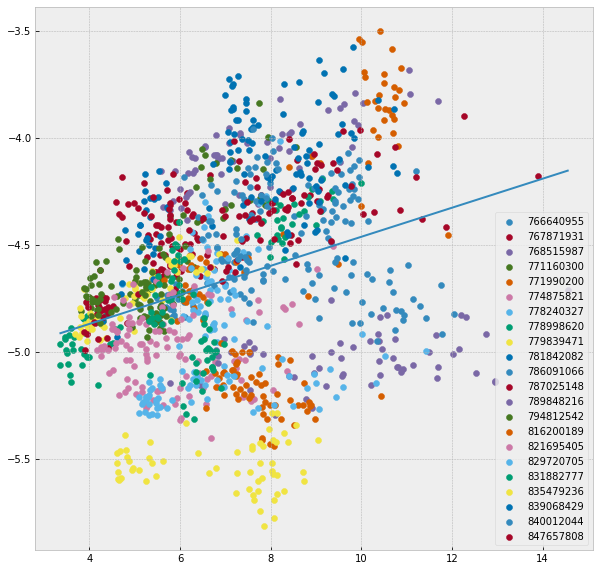

In [46]:
# Plot mean firing rate vs. broadband offset 

# plot each session
sessions = df.get('session').unique()
fig, ax = plt.subplots(figsize=(10, 10))
for ses in sessions:
    ses_df = df[df.get('session')==ses]
    ax.scatter(ses_df.get('mean_firing_rate'), ses_df.get('offset'), label=ses)
ax.legend()

# run regression across all epochs and plot results
x_data = df.get('mean_firing_rate')
y_data = df.get('offset')
results = sts.linregress(x_data, y_data)
l1 = np.linspace(min(x_data), max(x_data), 1000)
t1 = results.slope * l1 + results.intercept
ax.plot(l1, t1, label='natural_movie (1)')
print(results)


#### combine movie and shuffled results

In [47]:
# combine

# copy dataframe and add column for condition
df_movie = df.copy()
df_movie['condition'] = 'movie'

# repeat unit-lfp merge for shuffled data
df_lfp = shuffled_lfp_df.groupby(['session', 'epoch_idx']).mean().reset_index()
df_units = shuffled_synchrony_df.copy()
df_units = df_units[df_units.get("brain_structure")=="VISp"]    
# NOTE - spike_pipeline/3_compute_spike_stats.py has been updated to do this column renaming
df_units['session'] = df_units['session_id']
df_units['epoch_idx'] = np.nan
for ii in range(len(df_units)):
    df_units.loc[ii, 'epoch_idx'] = int(df_units.loc[ii, 'state'].split('_')[1])
df_shuffled = df_lfp.merge(df_units, on=['session', 'epoch_idx'])
df_shuffled['condition'] = 'shuffled'

# combine movie and shuffled dataframes
df = pd.concat([df_movie, df_shuffled])
print(len(df))
df.head()

1772


,session,epoch_idx,offset,knee,exponent,r_squared,cf_0,pw_0,bw_0,cf_1,...,coefficient_of_variation,SPIKE-distance,SPIKE-synchrony,correlation_coefficient,epoch,state,brain_structure,session_id,condition,Unnamed: 0
0,766640955,0.0,-4.860576,1188.476113,1.938520,0.920563,16.315592,0.527971,4.110032,67.971192,...,1.397554,0.373022,0.166795,[[ 1. 0.06956156 0.03174138 ... 0.0...,"[array(2297.21288415) * s, array(2327.21288415...",trial_0,VISp,766640955,movie,NaN
1,766640955,1.0,-4.840959,243.044655,1.958613,0.928544,16.089610,0.408364,4.154759,77.684014,...,1.805933,0.356343,0.156179,[[ 1. 0.28654797 -0.11920837 ... -0.2...,"[array(2327.23768415) * s, array(2357.23796415...",trial_1,VISp,766640955,movie,NaN
2,766640955,2.0,-4.734913,448.006152,2.018242,0.929696,20.044242,0.327437,3.952711,68.648654,...,2.085702,0.355914,0.144663,[[ 1. 0.52801102 -0.43696716 ... -0.2...,"[array(2357.26309415) * s, array(2387.26328415...",trial_2,VISp,766640955,movie,NaN
3,766640955,3.0,-4.808460,120.219652,1.976962,0.929683,14.305838,0.325696,6.565642,111.696998,...,2.286680,0.356209,0.150416,[[ 1. 0.30124503 -0.1708901 ... -0.2...,"[array(2387.28808415) * s, array(2417.28815415...",trial_3,VISp,766640955,movie,NaN
4,766640955,4.0,-4.841887,410.098697,1.968394,0.929065,30.627458,0.353131,4.655083,83.828503,...,1.927220,0.360086,0.148029,[[ 1. 0.19865689 -0.15139859 ... -0.2...,"[array(2417.31288415) * s, array(2447.31325415...",trial_4,VISp,766640955,movie,NaN



Regression results: movie
LinregressResult(slope=0.06782776872413715, intercept=-5.14071580236219, rvalue=0.3050832933063204, pvalue=1.051656335059755e-29, stderr=0.005845311753985733, intercept_stderr=0.042274833336342056)

Regression results: shuffled
LinregressResult(slope=0.03404763611868441, intercept=-5.1496720516350845, rvalue=0.19759306030472643, pvalue=2.0517398218778892e-05, stderr=0.007910152007073012, intercept_stderr=0.0581386161715553)


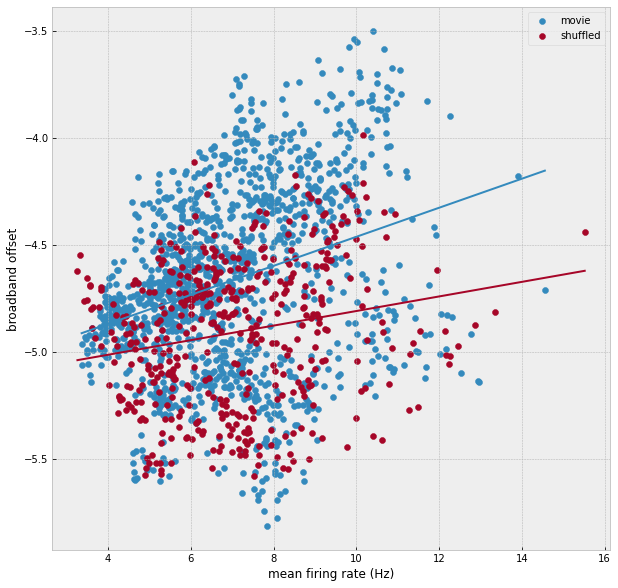

In [48]:
# plot mean firing rate vs. broadband offset for each condition

# create figure and label axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('mean firing rate (Hz)')
ax.set_ylabel('broadband offset')

# plot each condition
for condition in df.get('condition').unique():
    # plot scatter for each condition
    df_cond = df[df.get('condition')==condition]
    ax.scatter(df_cond.get('mean_firing_rate'), df_cond.get('offset'), label=condition)

    # run regression for both conditions and plot results
    x_data = df_cond.get('mean_firing_rate')
    y_data = df_cond.get('offset')
    results = sts.linregress(x_data, y_data)
    line_x = np.linspace(min(x_data), max(x_data), 1000)
    line_y = results.slope * line_x + results.intercept
    ax.plot(line_x, line_y)

    # print results
    print(f"\nRegression results: {condition}")
    print(results)

# add legend
ax.legend()
plt.show()

#### run anova

In [50]:
# run repeated measuresanova 

# average over epochs within each session
df_sessions = df.groupby(['session', 'condition']).mean().reset_index()

# drop row 26 (missing coresponding data)
# NOTE - why?
df_sessions = df_sessions.drop(index=26)

# loop over variables of interest
results = {}
for var in ['mean_firing_rate', 'offset', 'knee', 'exponent', 'coefficient_of_variation',
             'SPIKE-synchrony', 'SPIKE-distance']:
    # run anova
    results_i = sm.stats.AnovaRM(df_sessions, var, 'session', within=['condition']).fit()

    # aggregate
    results[var] = results_i

    # show results
    print(f"\n\n===================  {var}  ===================\n")
    print(results_i)



===================  mean_firing_rate  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  1.4166 1.0000 21.0000 0.2472



===================  offset  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 47.5672 1.0000 21.0000 0.0000



===================  knee  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 18.0739 1.0000 21.0000 0.0004



===================  exponent  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 43.8033 1.0000 21.0000 0.0000



===================  coefficient_of_variation  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  2.6892 1.0000 21.0000 

# Sensitivity Analysis

In [6]:
import pandas as pd
import numpy as np
import os
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_PATH = "G:/Shared drives/visual_encoding"
PSD_PATH = f"{PROJECT_PATH}/data/lfp_data/lfp_psd/natural_movie"
SPIKES_IN = 'data/spike_data/synchrony_data'

print("Packages Imported")

Packages Imported


In [7]:
# define functions for later use

def avg_psd_over_freq_ranges(freq, psd, lower_lims, upper_lims, log_transform=False):
    """
    Compute the average power spectral density (PSD) over frequency ranges for a given set of trials.

    Parameters
    ----------
    freq : array_like
        Array of frequencies.
    psd : array_like
        Array of PSD values.
    lower_lims: array_like
        Array of lower limits for frequency ranges.
    upper_lims: array_like
        Array of upper limits for frequency ranges.
    log_transform : bool, optional
        Whether to take the log10 of the PSD values before computing the average. Default is False.

    Returns
    -------
    mat : array_like
        3D array of average PSD values over frequency ranges for each trial.
    """
    # set upper and lower limits for frequency ranges
    num_trials = 60
    
    # intialize empty matrix for storage
    mat = np.empty((30, 30, 0))
    
    # loop through trials
    for trial in range(num_trials):
        
        # take median across channels
        psd_trial = np.median(psd[:,trial,:], axis=0)
        trial_mat = []
        
        # loop through upper/lower frequency limits
        for upper_lim in upper_lims:
            row = []
            for lower_lim in lower_lims:
                if upper_lim<=lower_lim:
                    row.append([np.nan])
                    continue
                    
                # filter for range and compute average
                psd_range = psd_trial[(freq>lower_lim) & (freq<upper_lim)]
                if log_transform:
                    psd_avg = np.mean(np.log10(psd_range))
                else:
                    psd_avg = np.mean(psd_range)
                row.append([psd_avg])
            trial_mat.append(row)
            
        # stack matrices for each trial
        mat = np.dstack((mat, trial_mat))
        
    return mat


def create_r_matrix(statistics, mat):    
    """
    Create a matrix of Pearson correlation coefficients between spike statistics and PSD data.

    Parameters
    ----------
    statistics : array_like
        Array of spike statistics.
    mat : array_like
        3D array of PSD data.

    Returns
    -------
    r_mat : array_like
        2D array of Pearson correlation coefficients.
    """
    # initialize matrix for storage of r values
    r_mat = []
    
    # loop through data in mat
    for i, row in enumerate(mat):
        r_mat_row = []
        for j, col in enumerate(row):
            all_trials = mat[i,j,:]
            
            # disregard invalid ranges
            if all(np.isnan(all_trials)):
                rcoeff = np.nan
            else:
                # some trials have NaN PSD data so filter those out
                rcoeff = sts.pearsonr(spike_stats[~np.isnan(all_trials)], \
                                      all_trials[~np.isnan(all_trials)])[0]
            r_mat_row.append(rcoeff)
        r_mat.append(r_mat_row)
        
    return r_mat


def plot_sa_heat_map(r_mat, xlabels, ylabels, graph_title=None):
    """
    Plot a sensitivity analysis heat map with -1 to 1 color map limits.

    Parameters
    ----------
    r_mat : array_like
        2D array of sensitivity analysis results.
    xlabels: array_like
        labels for x axis
    ylabels: array_like
        labels for y axis
    graph_title (optional): str
        title of heat map created

    Returns
    -------
    None

    """
    plt.figure(figsize=(14,7))
    sns.heatmap(r_mat, xticklabels=xlabels, yticklabels=ylabels, 
                vmin=-1, vmax=1, center=0, cmap='coolwarm')
    plt.xlabel("Lower Limit (Hz)")
    plt.ylabel("Upper Limit (Hz)")
    plt.xticks(rotation=30)
    
    if graph_title:
        plt.title(graph_title)

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_psd.npz
Analyzing File:	767871931_773462993_lfp_

C:\Users\User\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Analyzing File:	766640955_773592320_lfp_psd.npz


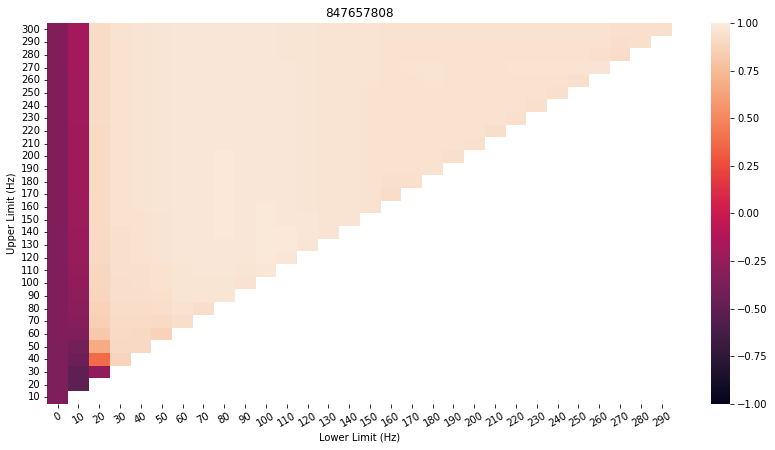

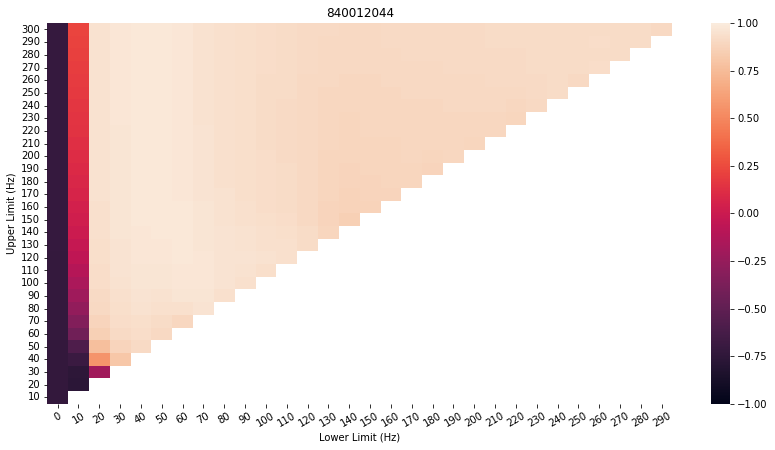

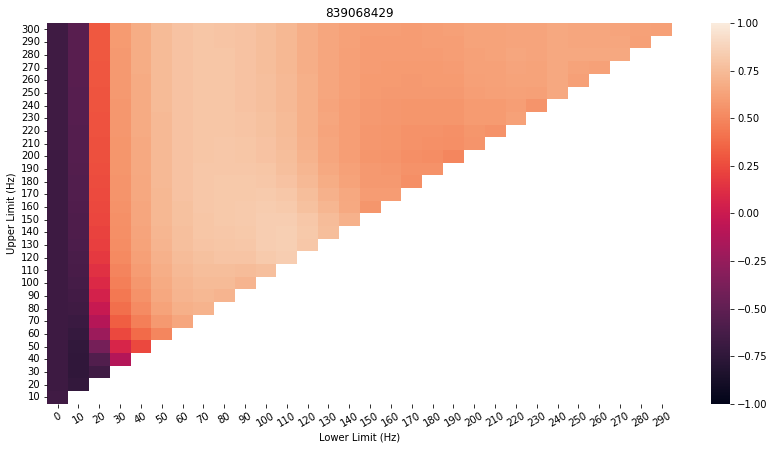

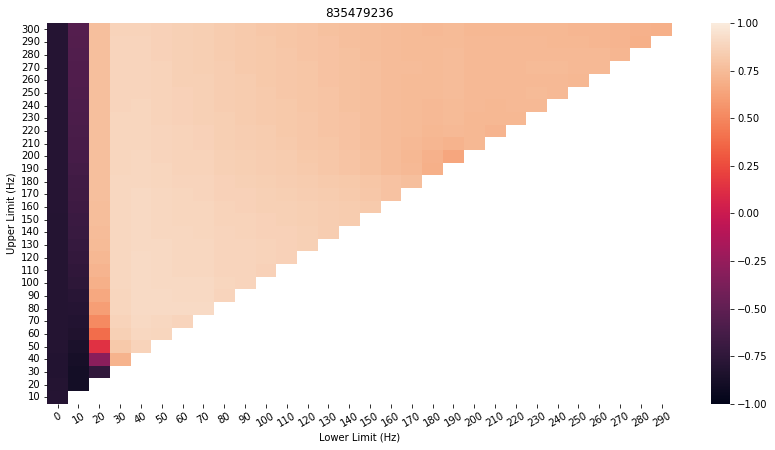

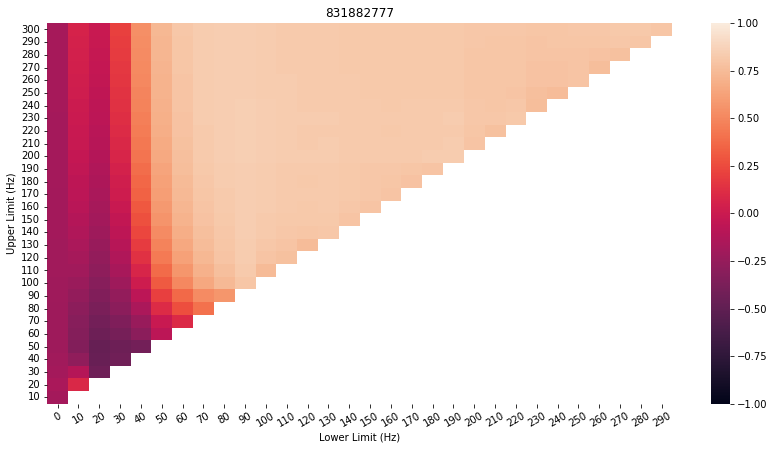

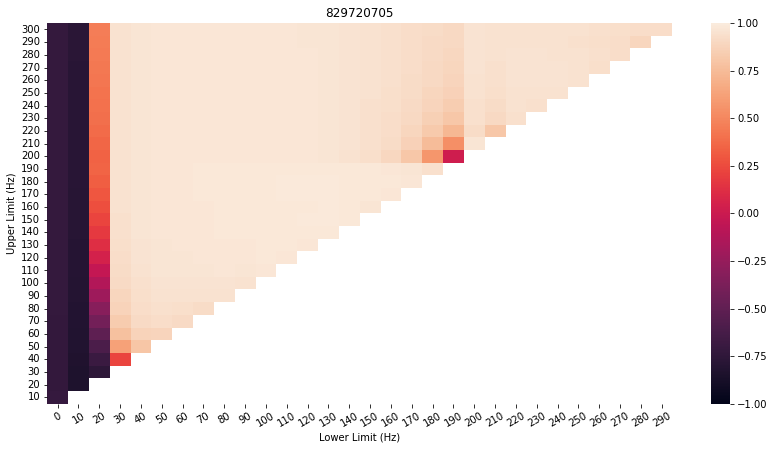

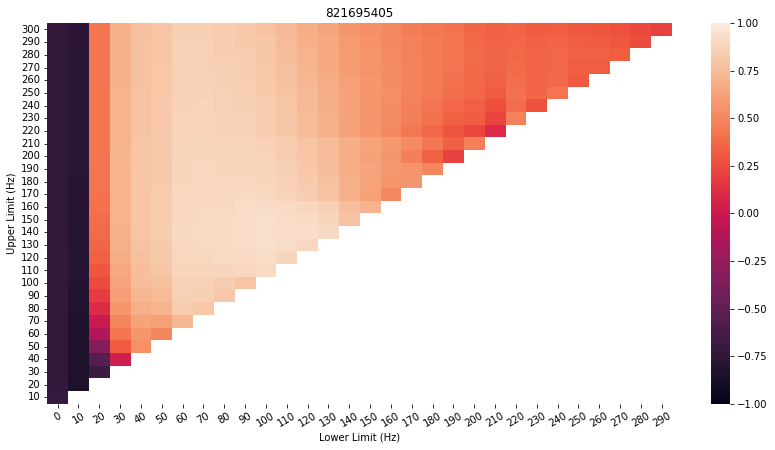

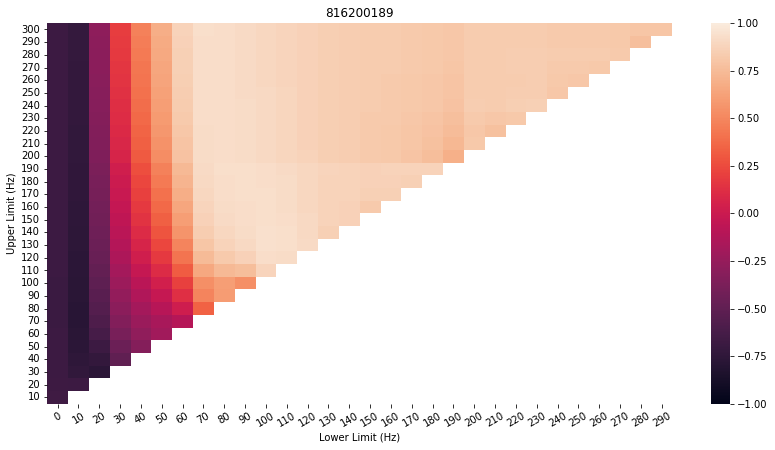

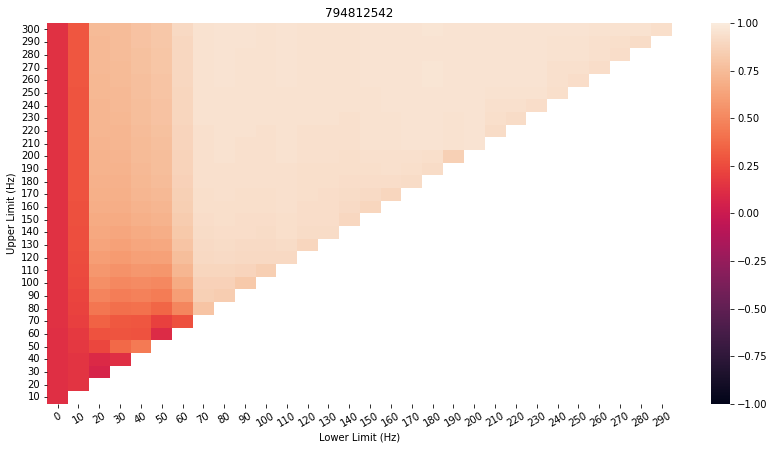

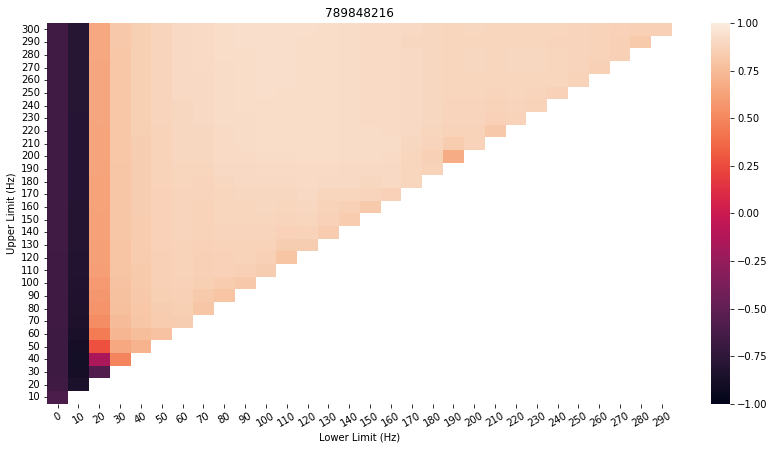

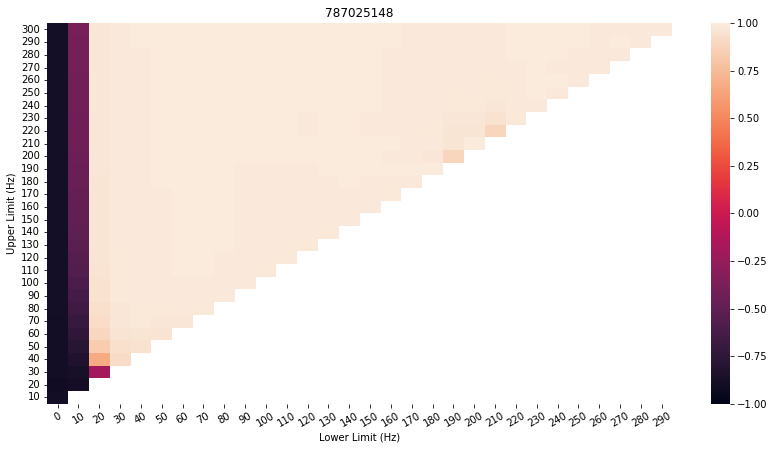

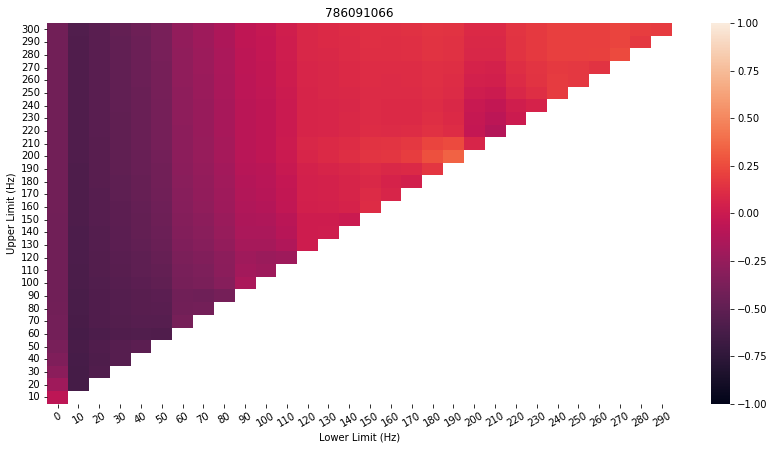

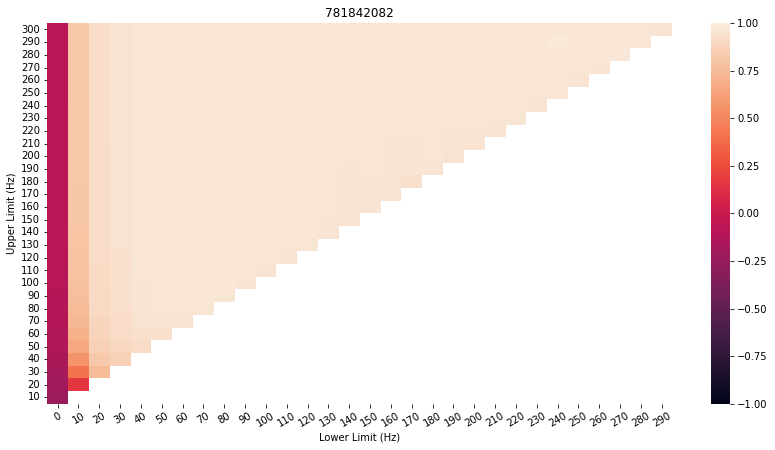

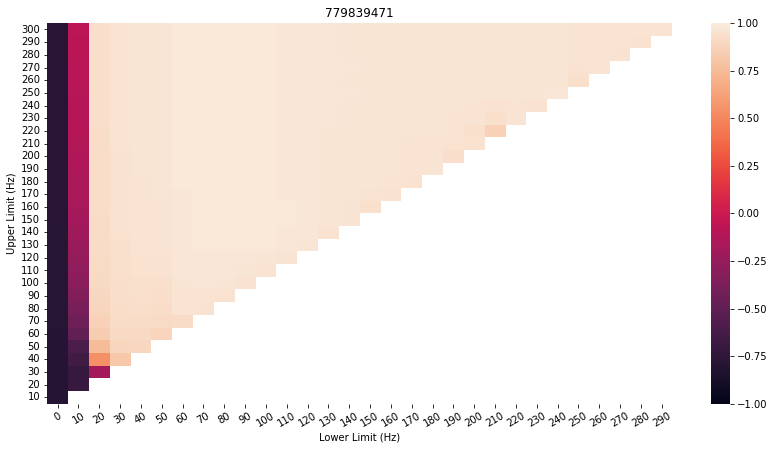

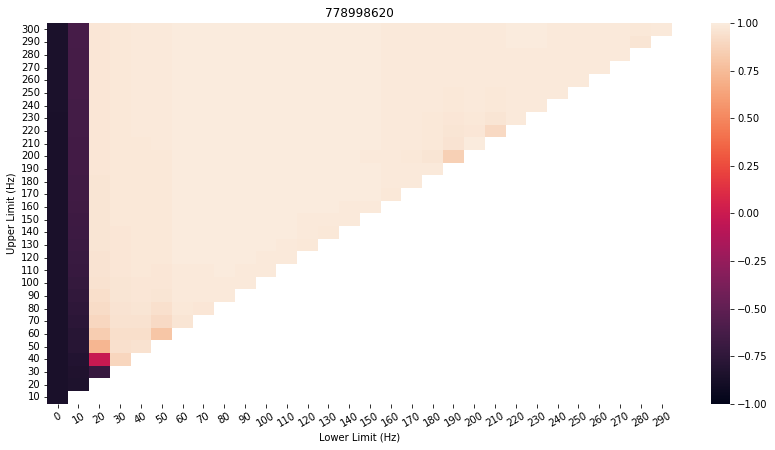

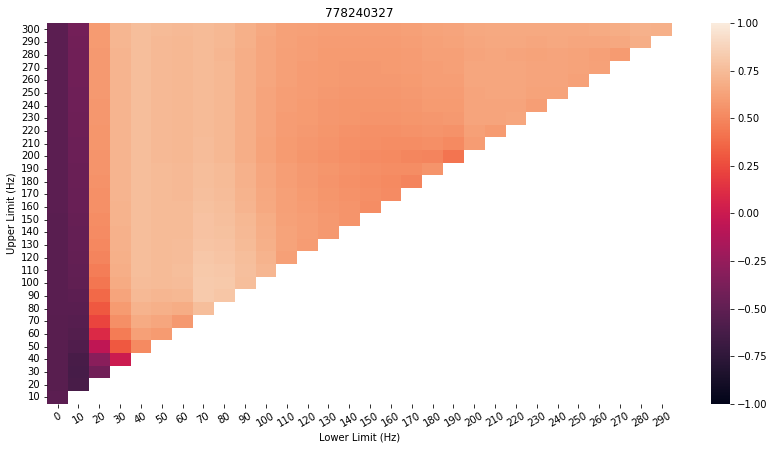

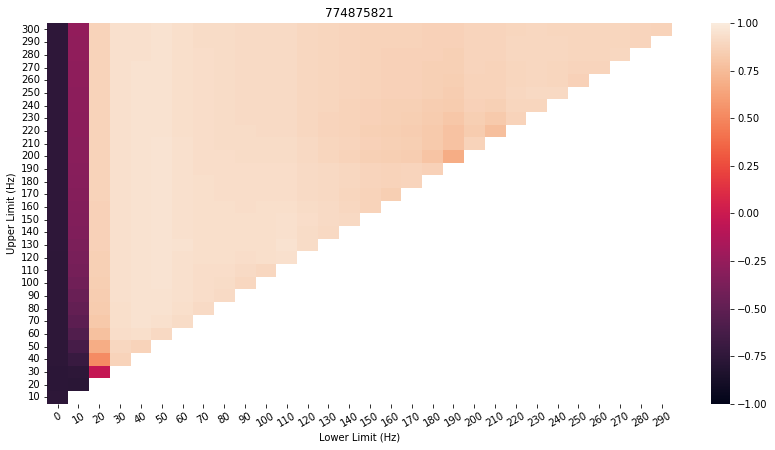

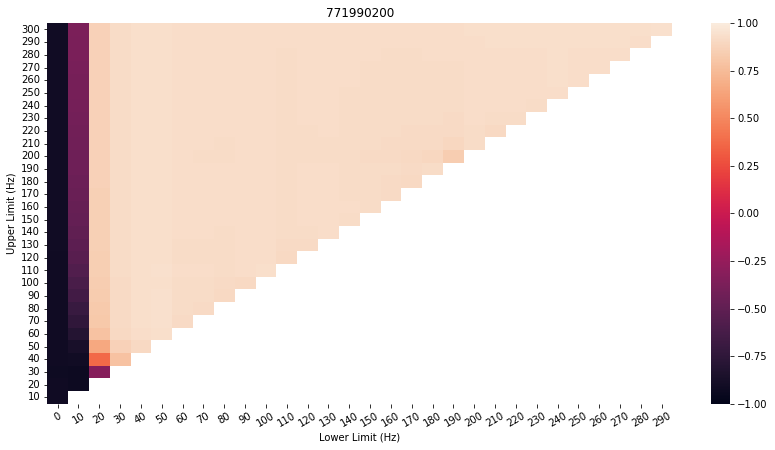

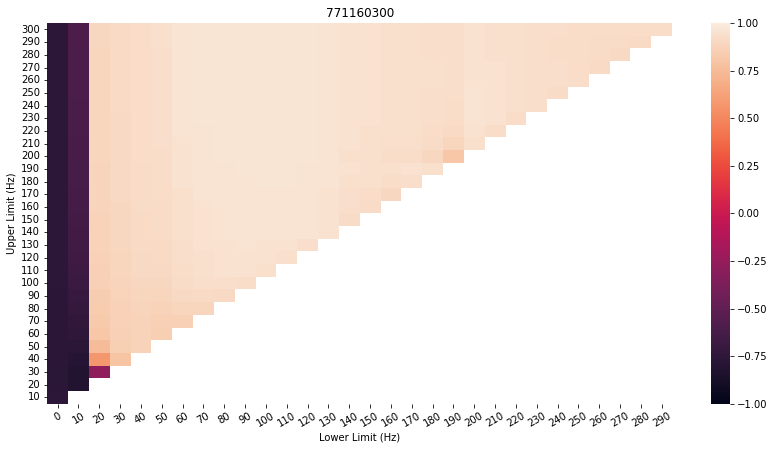

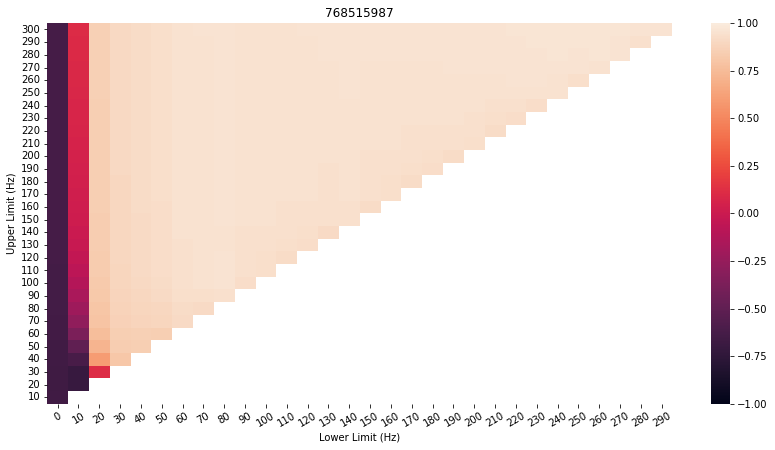

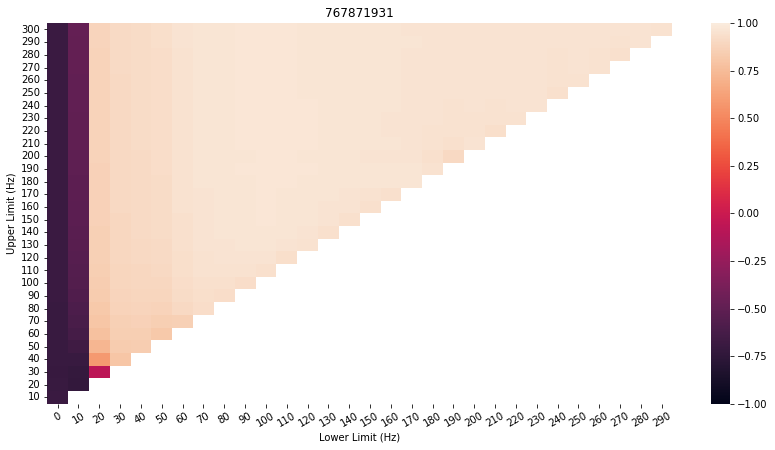

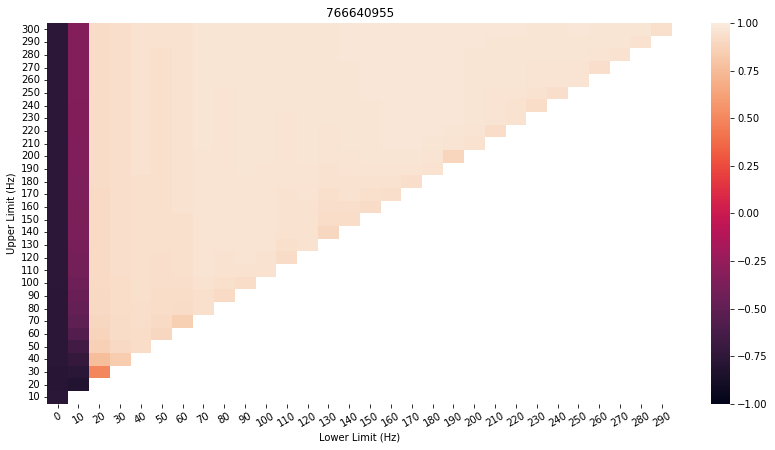

In [9]:
# load spike metric data
metric = 'mean_firing_rate'
movie_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie.csv')
vis_movie_synchrony_df = movie_synchrony_df[movie_synchrony_df.get('brain_structure')=='VISp']

# initialize matrix to hold all session data
all_sessions = np.empty((30, 30, 0))

# loop through all sessions/files
for file in os.listdir(PSD_PATH):
    
    # skip weird session with abnormal trial times/counts
    ses_id = int(file.split('_')[0])
    if ses_id == 793224716:
        continue
    
    # track progress
    print(f"Analyzing File:\t{file}")
    
    # load data
    data_in = np.load(f'{PSD_PATH}/{file}')
    psd, freq = data_in['psd'], data_in['freq']
    
    # calculate average psd over frequency ranges
    upper_lims = range(300, 0, -10)
    lower_lims = range(0, 300, 10)
    freq_range_mat = avg_psd_over_freq_ranges(freq, psd, lower_lims, upper_lims)
    
    # filter by session and get metric
    ses_id = int(file.split('_')[0])
    ses_df = vis_movie_synchrony_df[vis_movie_synchrony_df.get('session_id')==ses_id]
    spike_stats = ses_df.get(metric)

    # compute pearson R between average PSDs and spike metric values for each trial
    r_mat = create_r_matrix(spike_stats, freq_range_mat)
    
    # plot heat map of r values
    plot_sa_heat_map(r_mat, lower_lims, upper_lims, str(ses_id));
    
    # aggregate all sessions
    all_sessions = np.dstack((all_sessions, r_mat))

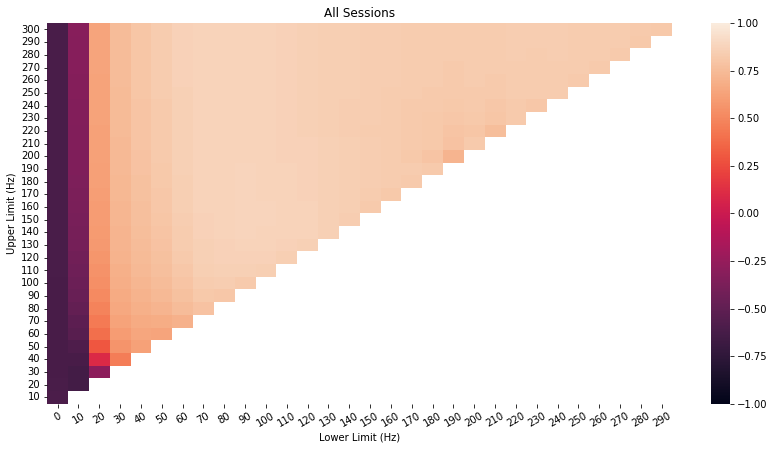

In [10]:
# look at a heat map showing average r values over all sessions
ses_avg_r_mat = np.mean(all_sessions, axis=2)
plot_sa_heat_map(ses_avg_r_mat, lower_lims, upper_lims, "All Sessions");

Analyzing File:	766640955_773592320_lfp_psd.npz
Analyzing File:	767871931_773462993_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Analyzing File:	847657808_848037572_lfp_psd.npz


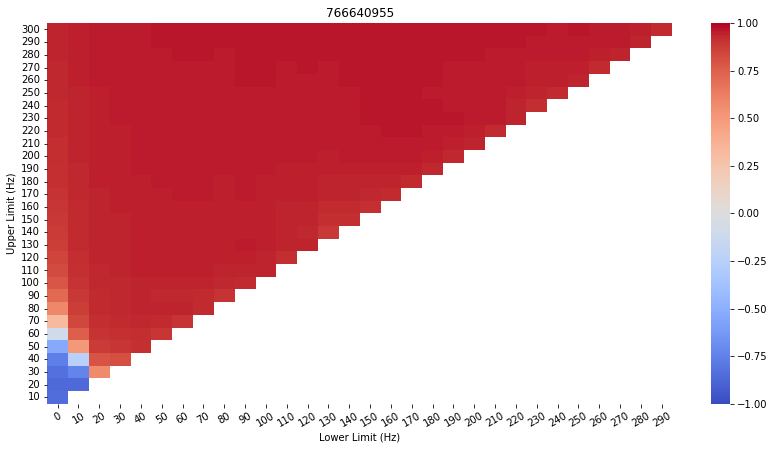

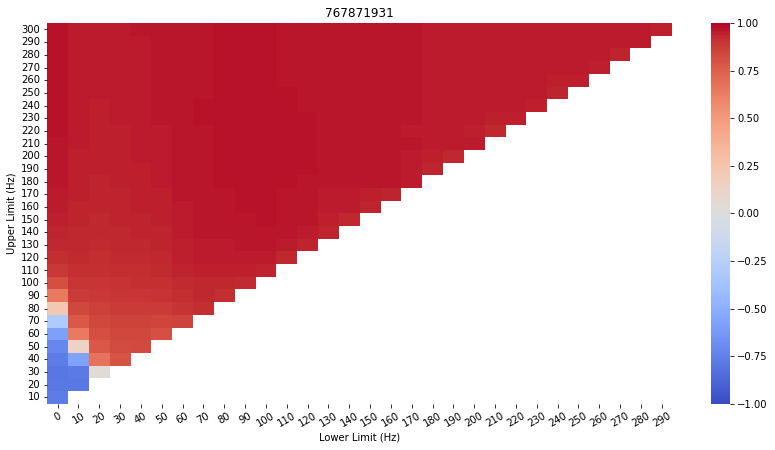

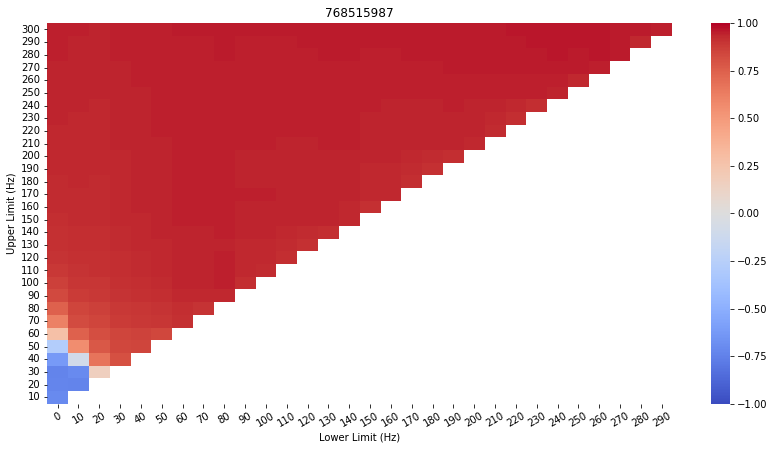

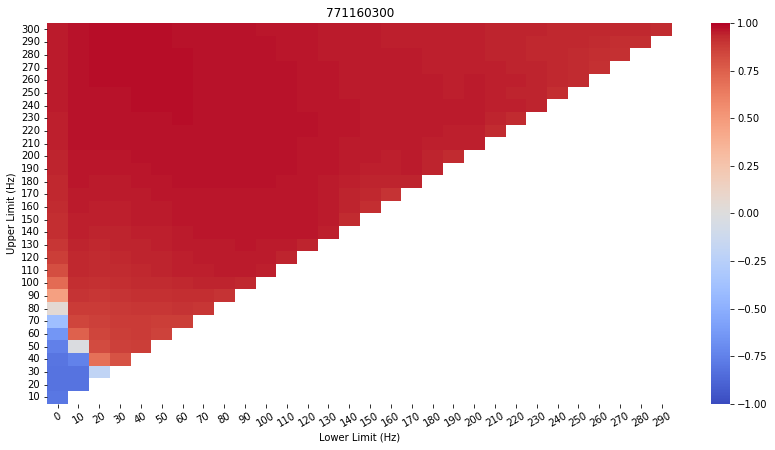

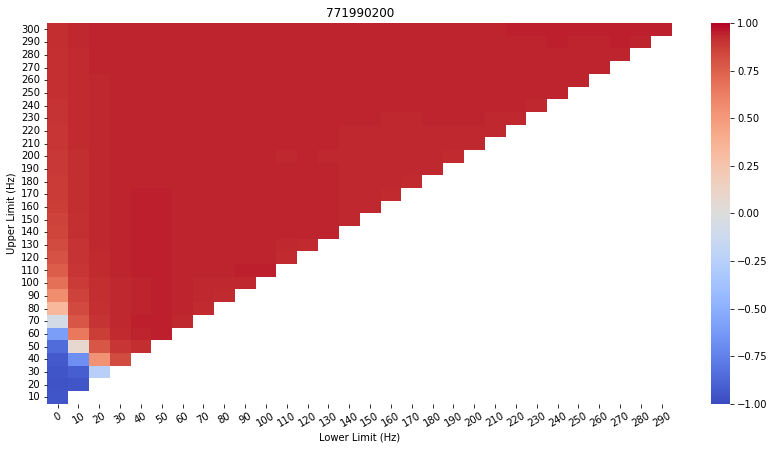

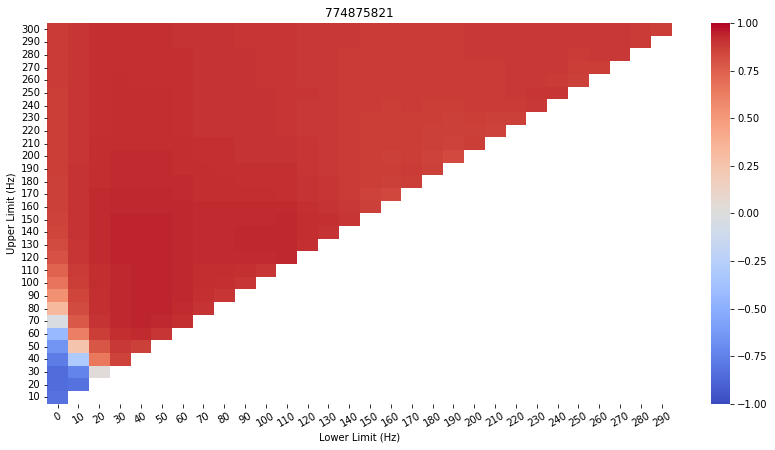

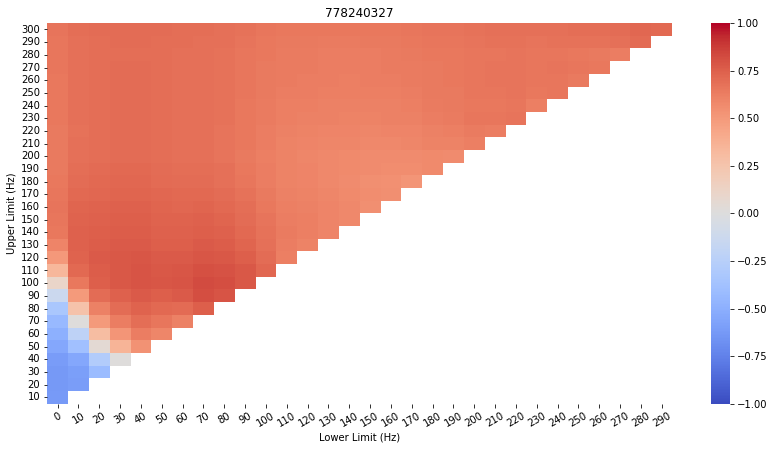

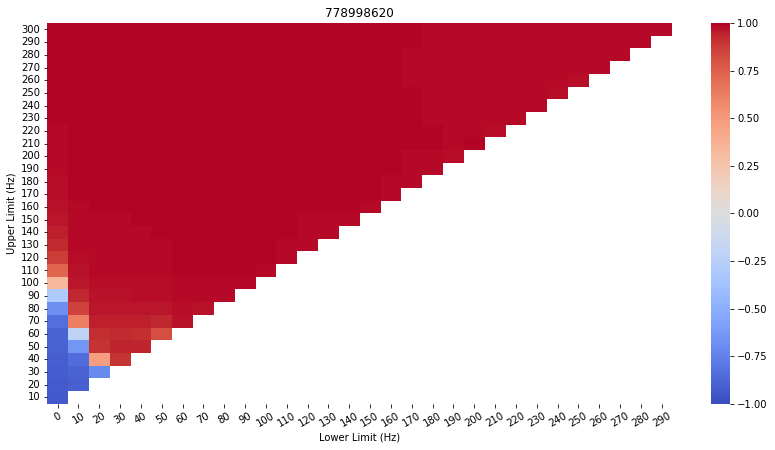

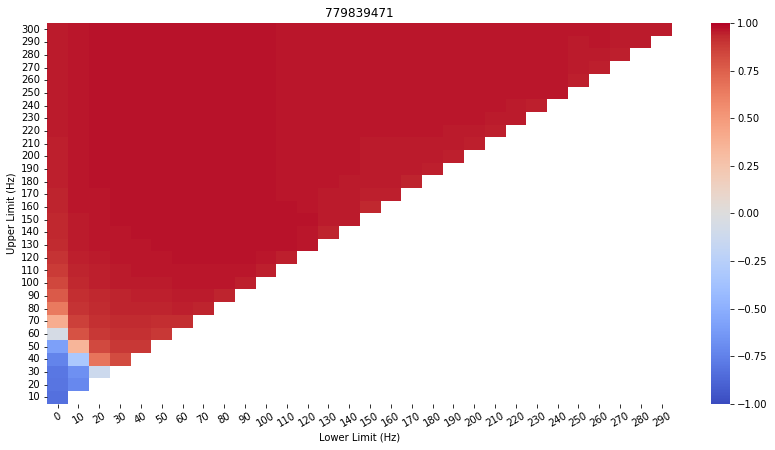

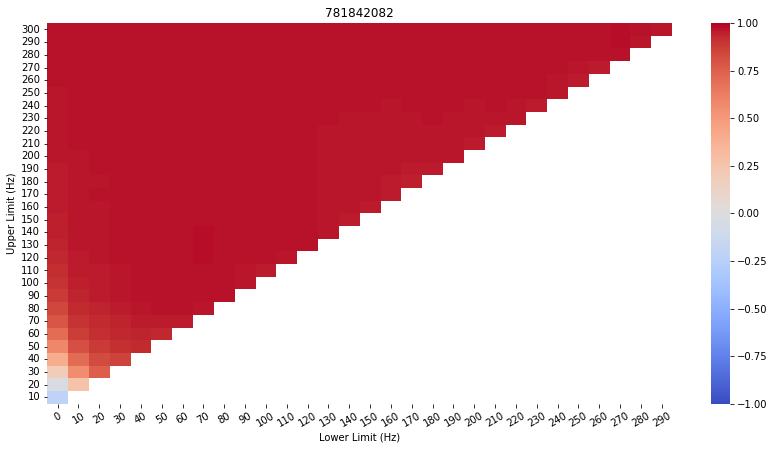

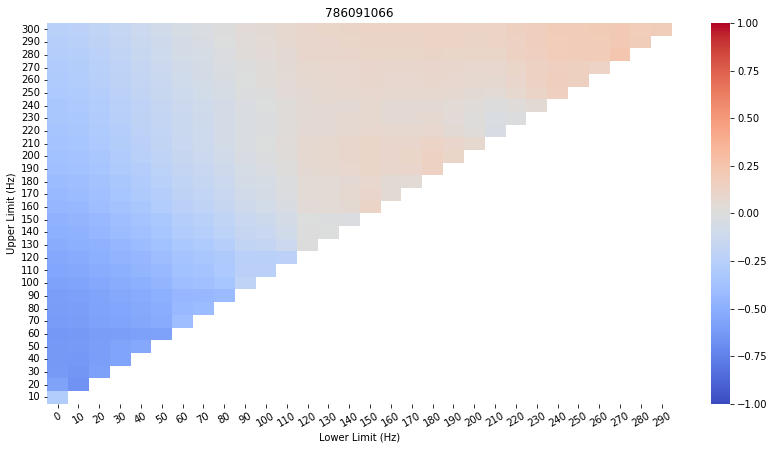

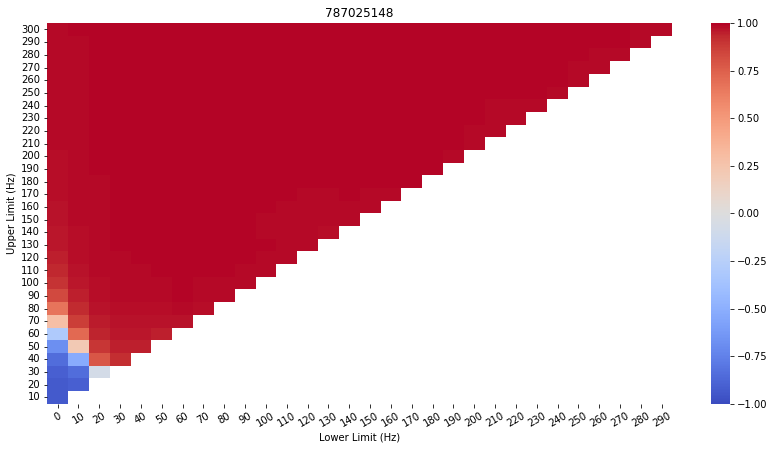

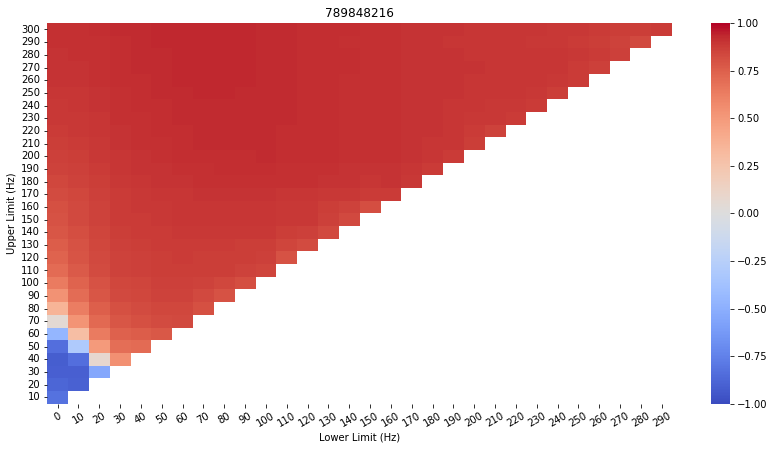

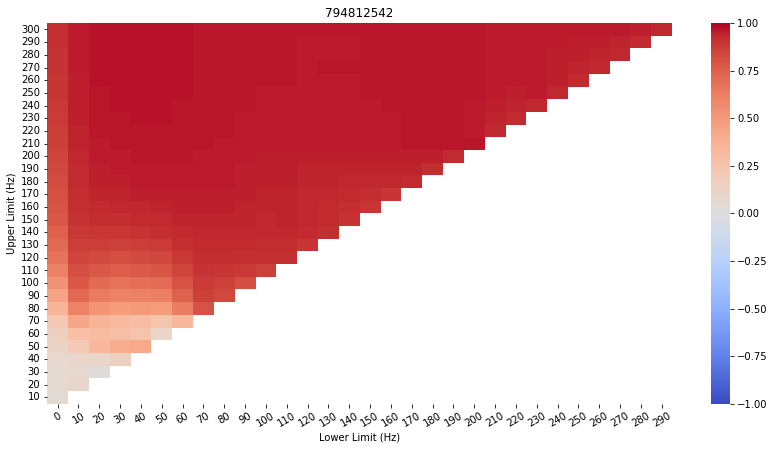

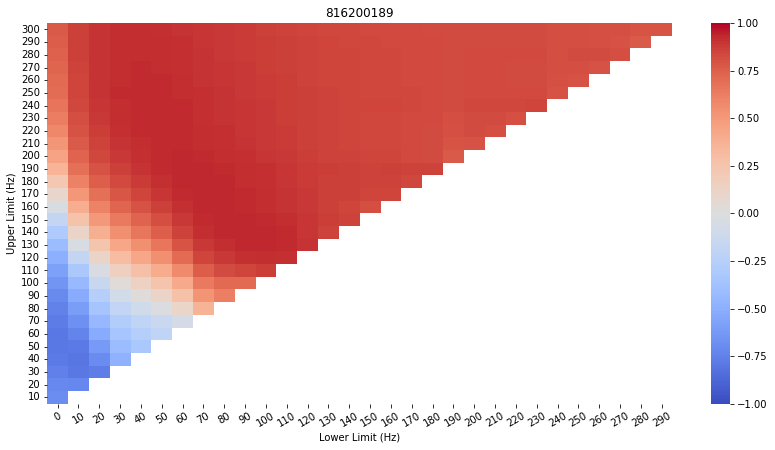

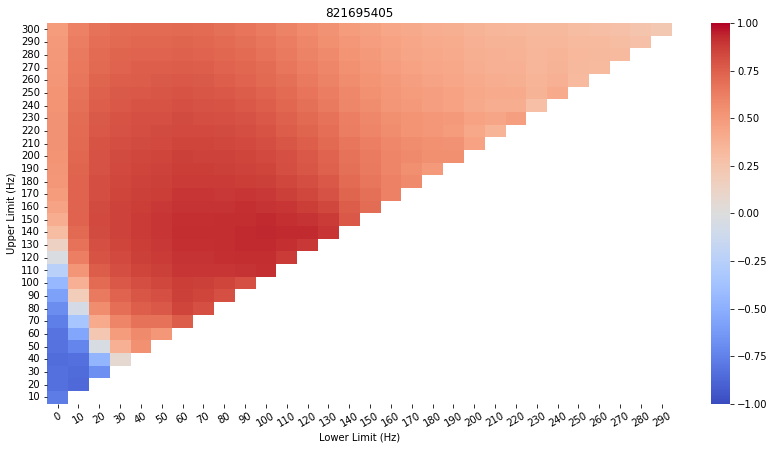

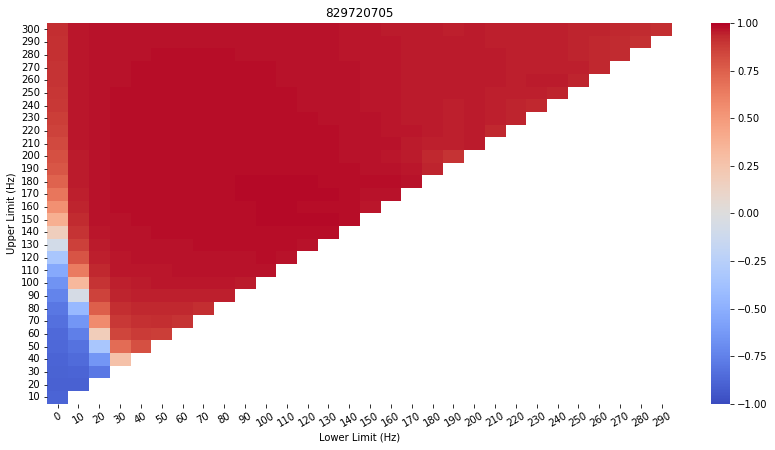

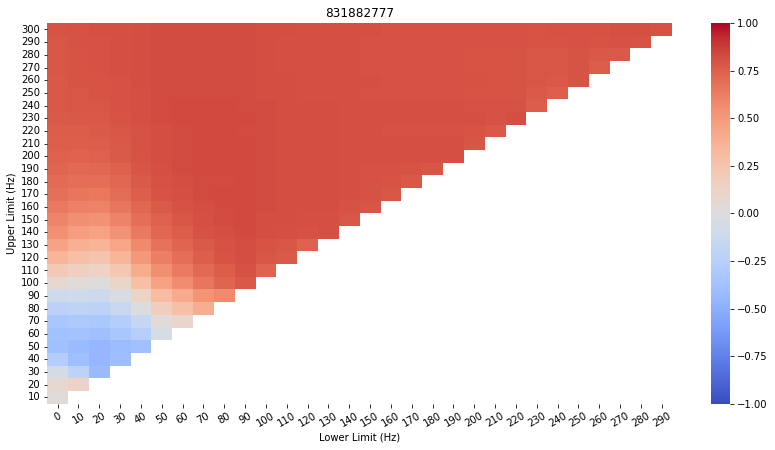

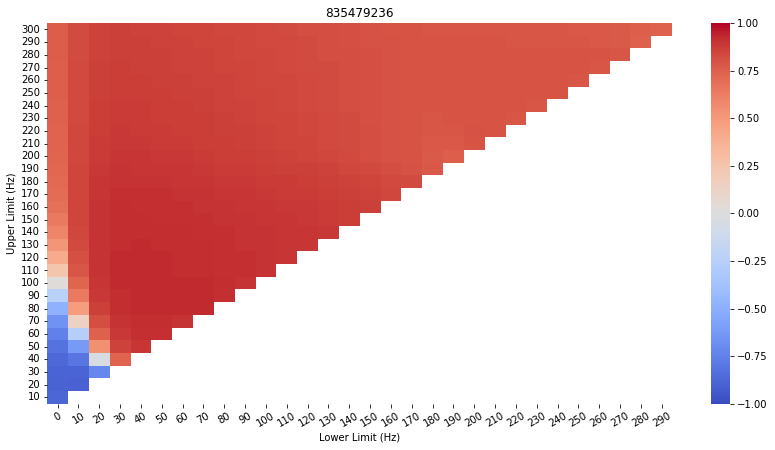

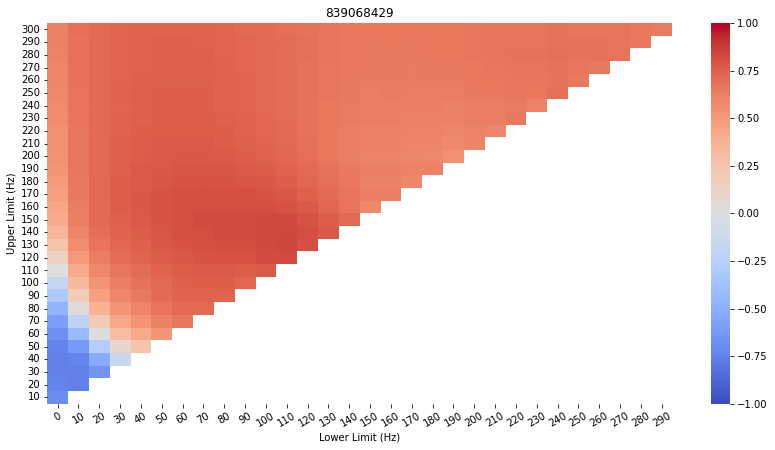

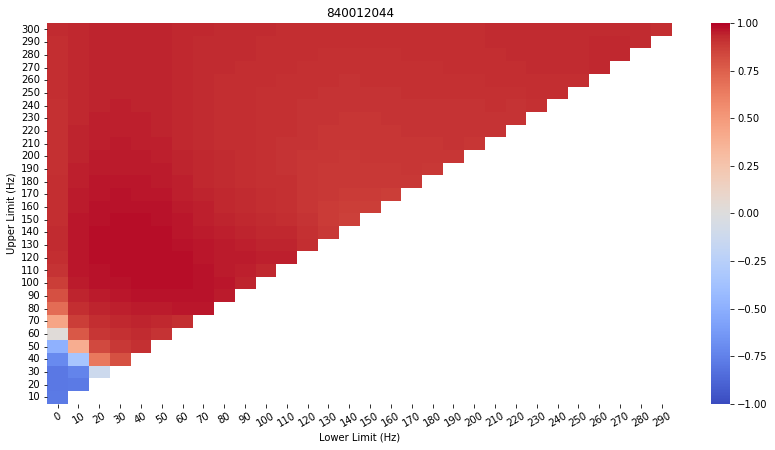

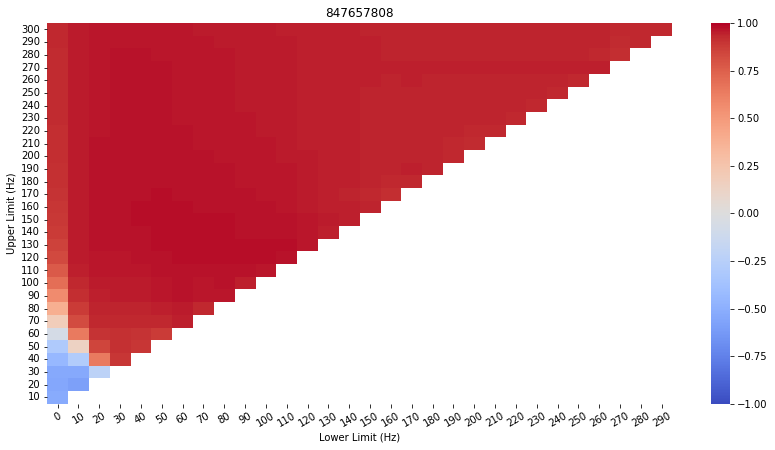

In [8]:
# this cell does the exact same thing as the previous but transforms (log10) the psd data prior to any further calculation


metric = 'mean_firing_rate'
movie_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie.csv')
vis_movie_synchrony_df = movie_synchrony_df[movie_synchrony_df.get('brain_structure')=='VISp']
all_sessions_log = np.empty((30, 30, 0))

for file in os.listdir(PSD_PATH):
    ses_id = int(file.split('_')[0])
    if ses_id == 793224716:
        continue
    print(f"Analyzing File:\t{file}")
    data_in = np.load(f'{PSD_PATH}/{file}')
    psd, freq = data_in['psd'], data_in['freq']
    upper_lims = range(300, 0, -10)
    lower_lims = range(0, 300, 10)
    
    # transform psd values by taking log10 of all values in range prior to average across range
    freq_range_mat = avg_psd_over_freq_ranges(freq, psd, lower_lims, upper_lims, log_transform=True)
    
    ses_id = int(file.split('_')[0])
    ses_df = vis_movie_synchrony_df[vis_movie_synchrony_df.get('session_id')==ses_id]
    spike_stats = ses_df.get(metric)
    r_mat = create_r_matrix(spike_stats, freq_range_mat)
    plot_sa_heat_map(r_mat, lower_lims, upper_lims, str(ses_id));
    all_sessions_log = np.dstack((all_sessions_log, r_mat))

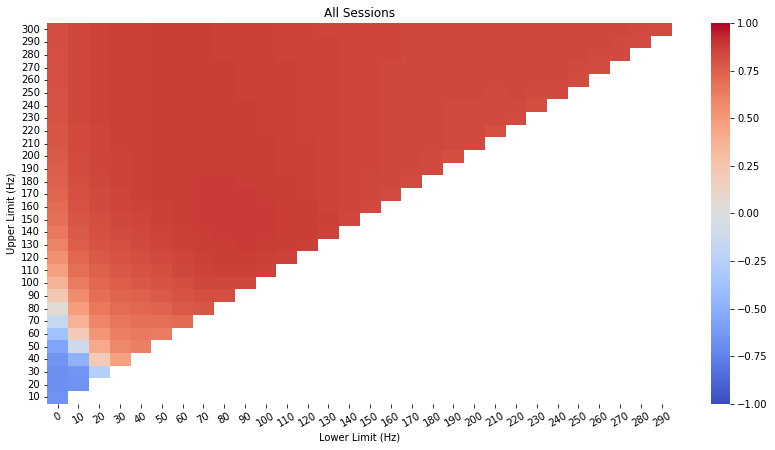

In [9]:
ses_avg_r_mat_log = np.mean(all_sessions_log, axis=2)
plot_sa_heat_map(ses_avg_r_mat_log, lower_lims, upper_lims, "All Sessions");

In [13]:
# should limits be inclusive?
# missing data for some trials in PSD (for all channels)